In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus, graphviz, time

from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, LeaveOneOut
from sklearn import preprocessing, linear_model, ensemble, svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from IPython.display import Image, display

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Features Descritpion :
1. Age
2. Sex
3. cp : Chest Pain Type : 
        -- Value 1: typical angina 
        -- Value 2: atypical angina 
        -- Value 3: non-anginal pain 
        -- Value 4: asymptomatic 
4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
5. chol : serum cholestoral in mg/dl
6. fbs : fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg : resting electrocardiographic results 
        -- Value 0: normal 
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST
           elevation or depression of > 0.05 mV) 
        -- Value 2: showing probable or definite left ventricular hypertrophy
           by Estes' criteria 
8. thalach : maximum heart rate achieved during exercise
9. exang : exercise induced angina (1 = yes; 0 = no)
10. oldpeak : ST depression induced by exercise relative to rest
11. slope : the slope of the peak exercise ST segment 
        -- Value 1: upsloping 
        -- Value 2: flat 
        -- Value 3: downsloping
12. ca : number of major vessels (0-3) colored by flourosopy 
13. thal : thalium heart scan 
        -- 3 = normal 
        -- 6 = fixed defect
        -- 7 = reversable defect
        
Predicted feature :
14. target : diagnosis of heart disease (angiographic disease status) 
        -- Value 0: < 50% diameter narrowing 
        -- Value 1: > 50% diameter narrowing 

In [5]:
X = df.drop(columns='target')
X = pd.get_dummies(X)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

--- 0.0029723644256591797 seconds ---


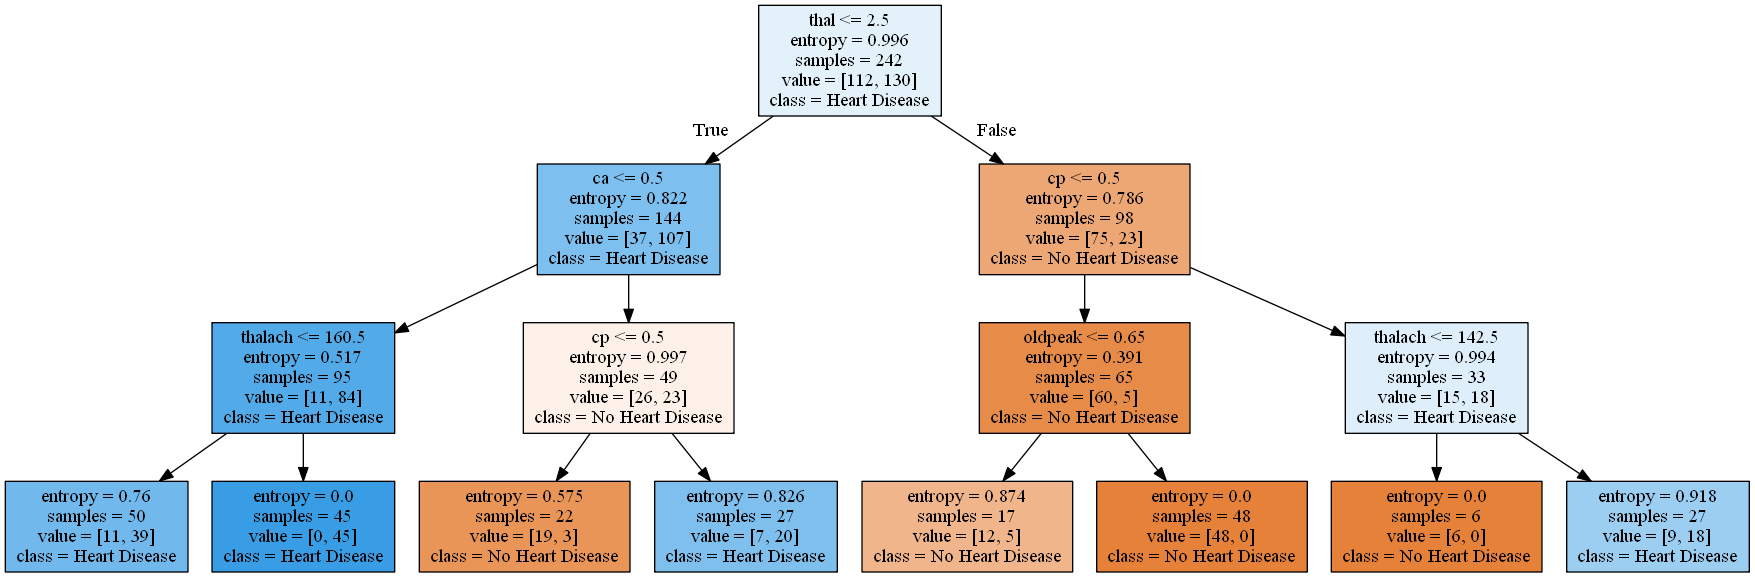

In [6]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=5,
    max_depth=3,
)

start_time = time.time()
decision_tree.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [7]:
df['old'] = np.where(df['age']>=56.6, 1, 0)
df['young'] = np.where(df['age']<=40, 1, 0)
df['high_col'] = np.where(df.chol >= 250, 1, 0)
df['high_bps'] = np.where(df.trestbps >= 130, 1, 0)
df['young_high_bps'] = np.where((df.trestbps <= 140) & (df.age <= 45), 1, 0)
df['chest_pain'] = np.where(df.cp >= 1, 1, 0)
df.sex = np.where(df.sex == 1, 'male', 'female')
df['sex_slope'] = df['sex'] + '_' + df['slope'].astype(str)

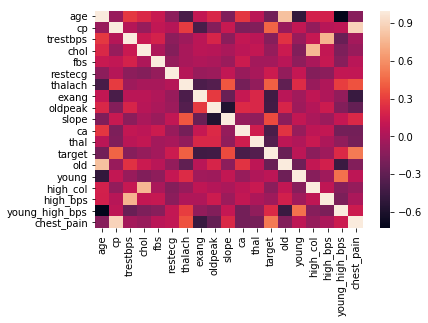

In [8]:
sns.heatmap(df.corr())

In [9]:
pd.options.display.max_columns = None
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,old,young,high_col,high_bps,young_high_bps,chest_pain,sex_slope
0,63,male,3,145,233,1,0,150,0,2.3,0,0,1,1,1,0,0,1,0,1,male_0
1,37,male,2,130,250,0,1,187,0,3.5,0,0,2,1,0,1,1,1,1,1,male_0
2,41,female,1,130,204,0,0,172,0,1.4,2,0,2,1,0,0,0,1,1,1,female_2
3,56,male,1,120,236,0,1,178,0,0.8,2,0,2,1,0,0,0,0,0,1,male_2
4,57,female,0,120,354,0,1,163,1,0.6,2,0,2,1,1,0,1,0,0,0,female_2


In [10]:
X = df.drop(columns='target')
X = pd.get_dummies(X)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [11]:
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
X_train_scaled.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,old,young,high_col,high_bps,young_high_bps,chest_pain,sex_female,sex_male,sex_slope_female_0,sex_slope_female_1,sex_slope_female_2,sex_slope_male_0,sex_slope_male_1,sex_slope_male_2
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,0.537793,0.305785,0.349992,0.280162,0.165289,0.268595,0.605451,0.351240,0.169888,0.704545,0.198347,0.782369,0.475207,0.053719,0.442149,0.533058,0.190083,0.504132,0.330579,0.669421,0.016529,0.152893,0.161157,0.049587,0.305785,0.314050
std,0.188638,0.339736,0.168348,0.123935,0.372211,0.265915,0.172378,0.478347,0.193566,0.306398,0.259503,0.200096,0.500420,0.225930,0.497671,0.499940,0.393179,0.501019,0.471396,0.471396,0.127762,0.360630,0.368438,0.217540,0.461694,0.465098
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.245283,0.192352,0.000000,0.000000,0.496183,0.000000,0.000000,0.500000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,0.333333,0.339623,0.265982,0.000000,0.500000,0.629771,0.000000,0.096774,0.500000,0.000000,0.666667,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.666667,0.433962,0.356164,0.000000,0.500000,0.725191,1.000000,0.290323,1.000000,0.250000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
classifiers = {'knn' : KNeighborsClassifier, 
               'forest' : ensemble.RandomForestClassifier,
               'logregr' : linear_model.LogisticRegression,
               'ridge' : linear_model.RidgeClassifier,
               'svc' : svm.SVC,
               'boosting' : ensemble.GradientBoostingClassifier
              }

clf_grid = {'knn' : {'n_neighbors' : [1, 5, 10, 15], 
                     'weights' : ['uniform', 'distance'],
                     'algorithm' : ['ball_tree', 'kd_tree', 'brute']},
            'forest' : {'n_estimators' : [100, 500, 1000],
                        'criterion' : ['gini', 'entropy'], 
                        'max_depth' : [2, 5, 10]},
            'logregr' : {'penalty' : ['l1', 'l2'], 
                         'tol' : [1e-3, 1e-4, 1e-5], 
                         'C' : [1, 1e-2, 1e-4], 
                         'solver' : ['liblinear']},
            'ridge' : {'alpha' : [1, 100, 1000], 
                       'tol' : [1e-3, 1e-4, 1e-5], 
                       'solver' : ['svd', 'cholesky', 'lsqr']}, #, ‘sparse_cg’, ‘sag’, ‘saga’,
            'svc' : {'C' : [1, 1e-2, 1e-3], 
                     'kernel' : ['linear', 'rbf'],  #, 'poly'
                     'gamma' : ['auto']},
            'boosting' : {'n_estimators': [100, 500, 1000],
                          'max_depth': [2, 3, 4],
                          'loss': ['deviance', 'exponential'],
                          'subsample' : [0.4, 0.8, 1]}
           }

In [14]:
def grid_search(X_train, X_test, y_train, y_test):
    results = pd.DataFrame()
    for method in classifiers.keys():
        classifier, parameters = classifiers[method](), clf_grid[method]
        for parameter_set in ParameterGrid(parameters):
            start_time = time.time()
            print('{} {}'.format(method, list(parameter_set.values())[:]))
            
            classifier.set_params(**parameter_set)
            classifier.fit(X_train, y_train.values.ravel())
            y_pred = classifier.predict(X_test)
            
            if (method == 'ridge') or (method == 'svc'):
                #d = classifier.decision_function(X_test)[0]
                #y_prob = np.exp(d) / np.sum(np.exp(d))
                Auroc = 0.5
            else:
                y_prob = classifier.predict_proba(X_test)[:,1] #More expensive
                Auroc = roc_auc_score(y_test, y_prob) #More expensive
                
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            Accuracy = accuracy_score(y_test, y_pred)
            Precision = precision_score(y_test, y_pred)
            Recall = recall_score(y_test, y_pred)
        
            df2 = pd.DataFrame([(method, parameter_set.values(), Accuracy, Precision, Recall, Auroc, fn, fp)], 
                           columns = ['Method' , 'Parameters', 'Accuracy', 'Precision' , 
                                      'Recall', 'Auroc', 'False negative', 'False positive'])
            results = results.append(df2, ignore_index=True)
            
            total_time = time.time() - start_time
            print('Done in {} seconds'.format(total_time))
        
    return results

In [15]:
results =  grid_search(X_train, X_test, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.011966943740844727 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.009958744049072266 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.00998544692993164 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.009979248046875 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.00797891616821289 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.008977651596069336 seconds
knn ['ball_tree', 15, 'uniform']
Done in 0.008968591690063477 seconds
knn ['ball_tree', 15, 'distance']
Done in 0.007979869842529297 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.008976221084594727 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.00797891616821289 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.007977962493896484 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.008977174758911133 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.007979393005371094 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.008974075317382812 seconds
knn ['kd_tree', 15, 'uniform']
Done in 

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.06781864166259766 seconds
ridge [1, 'svd', 0.0001]
Done in 0.007979154586791992 seconds
ridge [1, 'svd', 1e-05]
Done in 0.016953706741333008 seconds
ridge [1, 'cholesky', 0.001]
Done in 0.005984783172607422 seconds
ridge [1, 'cholesky', 0.0001]
Done in 0.010971307754516602 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.008975505828857422 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.008972644805908203 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.007977724075317383 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.012967824935913086 seconds
ridge [100, 'svd', 0.001]
Done in 0.007976055145263672 seconds
ridge [100, 'svd', 0.0001]
Done in 0.007979393005371094 seconds
ridge [100, 'svd', 1e-05]
Done in 0.009972333908081055 seconds
ridge [100, 'cholesky', 0.001]
Done in 0.00797891616821289 seconds
ridge [100, 'cholesky', 0.0001]
Done in 0.016955137252807617 seconds
ridge [100, 'cholesky', 1e-05]
Done in 0.011967897415161133 seconds
ridge [100, 'lsqr', 0.001]
Done in 0.006981611251831055 secon

In [16]:
results.sort_values(by='Recall', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc,False negative,False positive
90,svc,"(0.01, auto, rbf)",0.557377,0.557377,1.000000,0.500000,0,27
92,svc,"(0.001, auto, rbf)",0.557377,0.557377,1.000000,0.500000,0,27
88,svc,"(1, auto, rbf)",0.573770,0.568966,0.970588,0.500000,1,25
122,boosting,"(exponential, 2, 100, 1)",0.770492,0.727273,0.941176,0.858388,2,12
141,boosting,"(exponential, 4, 500, 0.4)",0.786885,0.744186,0.941176,0.858388,2,11
89,svc,"(0.01, auto, linear)",0.770492,0.727273,0.941176,0.500000,2,12
132,boosting,"(exponential, 3, 500, 0.4)",0.786885,0.744186,0.941176,0.859477,2,11
73,ridge,"(100, cholesky, 0.0001)",0.786885,0.756098,0.911765,0.500000,3,10
96,boosting,"(deviance, 2, 500, 0.4)",0.754098,0.720930,0.911765,0.856209,3,12
69,ridge,"(100, svd, 0.001)",0.786885,0.756098,0.911765,0.500000,3,10


In [17]:
results.groupby('Method').mean()

,Accuracy,Precision,Recall,Auroc,False negative,False positive
Method,,,,,,
boosting,0.760170,0.734244,0.893246,0.854091,3.629630,11.000000
forest,0.740437,0.723661,0.864379,0.856814,4.611111,11.222222
knn,0.610656,0.648248,0.665441,0.633102,11.375000,12.375000
logregr,0.686703,0.613725,0.683007,0.744311,10.777778,8.333333
ridge,0.757741,0.753508,0.844227,0.500000,5.296296,9.481481
svc,0.655738,0.652025,0.916667,0.500000,2.833333,18.166667


In [19]:
#best = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10)
best = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=4, n_estimators=500, subsample=0.4)

In [20]:
np.mean(cross_val_score(best, X, y, cv=10, scoring='recall'))

0.8533088235294117

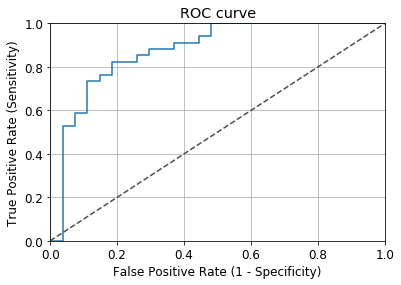

In [22]:
best.fit(X_train,y_train)
y_pred_quant = best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
loo = LeaveOneOut()
results_2 = pd.DataFrame()
for train_index, test_index in loo.split(X):
    
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    best.fit(X_train, y_train.values.ravel())
    y_pred = best.predict(X_test)
    #y_prob = best.predict_proba(X_test)[:,1] #More expensive
    
    #Auroc = roc_auc_score(y_test, y_prob) #More expensive
    #tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    Accuracy = accuracy_score(y_test, y_pred)
    #Precision = precision_score(y_test, y_pred)
    #Recall = recall_score(y_test, y_pred)

    df3 = pd.DataFrame([Accuracy], columns = ['Accuracy'])
    
    results_2 = results_2.append(df3, ignore_index=True)

In [ ]:
results_2.Accuracy.value_counts()

In [23]:
results_scaled =  grid_search(X_train_scaled, X_test_scaled, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.010991573333740234 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.010970115661621094 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.0109710693359375 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.008976221084594727 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.007997751235961914 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.007958173751831055 seconds
knn ['ball_tree', 15, 'uniform']
Done in 0.008975982666015625 seconds
knn ['ball_tree', 15, 'distance']
Done in 0.008977890014648438 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.007999897003173828 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.009971141815185547 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.008981466293334961 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.010945320129394531 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.010970592498779297 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.012967109680175781 seconds
knn ['kd_tree', 15, 'uniform']
Done

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMe

Done in 0.007978439331054688 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.008975982666015625 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.007982254028320312 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.010967254638671875 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.016954421997070312 seconds
ridge [100, 'svd', 0.001]
Done in 0.009972810745239258 seconds
ridge [100, 'svd', 0.0001]
Done in 0.023936986923217773 seconds
ridge [100, 'svd', 1e-05]
Done in 0.00897526741027832 seconds
ridge [100, 'cholesky', 0.001]
Done in 0.006984233856201172 seconds
ridge [100, 'cholesky', 0.0001]
Done in 0.005982398986816406 seconds
ridge [100, 'cholesky', 1e-05]
Done in 0.00598454475402832 seconds
ridge [100, 'lsqr', 0.001]
Done in 0.007978677749633789 seconds
ridge [100, 'lsqr', 0.0001]
Done in 0.006983280181884766 seconds
ridge [100, 'lsqr', 1e-05]
Done in 0.005982160568237305 seconds
ridge [1000, 'svd', 0.001]
Done in 0.006981372833251953 seconds
ridge [1000, 'svd', 0.0001]
Done in 0.005984067916870117 sec

In [24]:
results_scaled.sort_values(by='Recall', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc,False negative,False positive
90,svc,"(0.01, auto, rbf)",0.557377,0.557377,1.000000,0.500000,0,27
92,svc,"(0.001, auto, rbf)",0.557377,0.557377,1.000000,0.500000,0,27
91,svc,"(0.001, auto, linear)",0.557377,0.557377,1.000000,0.500000,0,27
81,ridge,"(1000, cholesky, 0.001)",0.688525,0.653061,0.941176,0.500000,2,17
57,logregr,"(0.0001, l2, liblinear, 0.001)",0.672131,0.640000,0.941176,0.823529,2,18
58,logregr,"(0.0001, l2, liblinear, 0.0001)",0.672131,0.640000,0.941176,0.822440,2,18
59,logregr,"(0.0001, l2, liblinear, 1e-05)",0.672131,0.640000,0.941176,0.822440,2,18
122,boosting,"(exponential, 2, 100, 1)",0.770492,0.727273,0.941176,0.858388,2,12
114,boosting,"(deviance, 4, 500, 0.4)",0.786885,0.744186,0.941176,0.874728,2,11
24,forest,"(gini, 2, 100)",0.770492,0.727273,0.941176,0.861656,2,12


In [25]:
#best_scaled = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2)
best_scaled = ensemble.GradientBoostingClassifier(loss='deviance', max_depth=4, n_estimators=500, subsample=0.4)

In [26]:
np.mean(cross_val_score(best_scaled, X, y, cv=10, scoring='recall'))

0.8349264705882351